___
**Mood:**
- A state of mind that is not as specific as emotion
- Biases which emotions are felt (DOI:10.1080/10803548.2003.11076589)
___
**Behavioral correlates with mood include**
- Voice modulation (May have something like this through speech telephony)
- Gestures
- Cognitive performance
- Cognitive strategy
- Motor behavior (Is like errors when pressing keys?)
- (DOI:10.1080/10803548.2003.11076589)
___

**Keyboard stokes may predict future moods.**
- But it is not known over how long the data needs to be collected for prediction to be reliable
(https://doi.org/10.1016/j.asej.2021.101660)
___

**Data Available to us**
- Phone Usage
- Speech Telephony
- Keyboard Metrics
___
**Data that seems interesting**
- Total Error Distances
- Total Corrections
- Emoji Counts
- Total ScreenTime
___
**Data that can be used as labels**
- Self report survey scores
- Calculated IB Gaps
___

In [1]:
import pandas as pd
import numpy as np
import pickle
import datetime
import json
import re
import os, gzip, shutil, fnmatch

import sklearn
import matplotlib

from sklearn import preprocessing
from matplotlib import pyplot as plt 

In [26]:
## data directory
directory = "/Users/farhan/DNL/BuddingScholar/Budding_Scholar_22-23/Data/"

In [27]:
## Good Subjects

# participant = "1e7aef96-16cc-43f8-95d4-e3bc582eb6d3/2017C676-C22A-4318-903C-7544760252BB/"
participant = "2baee05a-5e5a-4436-8c25-2628d46d1e08/4684F36F-66CC-4FB1-9383-3BC2B008D365/"

In [28]:
## Concerned with keyboard metric for now
metric_folder = "sensorkit-keyboard-metrics/iPhone"

___
##### Functions to unzip files in a folder
- Function will unzip all files in a given directory
___

In [29]:
## Recursively unzip everything

def gunzip(file_path, output_path):
    with gzip.open(file_path,"rb") as f_in, open(output_path,"wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

def recurse_and_gunzip(root):
    walker = os.walk(root)
    for rootx,dirs,files in walker:
        for f in files:
            if fnmatch.fnmatch(f,"*.gz"):
                gunzip(rootx+"/"+f, rootx+"/"+f.replace(".gz",""))

In [30]:

## Iterative decompression
def gz_extract(directory):
    extension = ".gz"
    os.chdir(directory)
    for item in os.listdir(directory): # loop through items in dir
      if item.endswith(extension): # check for ".gz" extension
          gz_name = os.path.abspath(item) # get full path of files
          file_name = (os.path.basename(gz_name)).rsplit('.',1)[0] #get file name for file within
          with gzip.open(gz_name,"rb") as f_in, open(file_name,"wb") as f_out:
            print(gz_name)
            shutil.copyfileobj(f_in, f_out)
          os.remove(gz_name) # delete zipped file

____
#### Date and Time Functions
____

In [31]:
def fix_date_to_ET(end_date):
    if pd.to_datetime(end_date, format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').hour < 5:
        return pd.to_datetime(end_date, format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date() - datetime.timedelta(days=1)
    else:
        return pd.to_datetime(end_date, format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()


def get_date_from_timestamp(timestamp):
    return pd.to_datetime(timestamp, format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()

def get_time_from_timestamp(timestamp):
    return pd.to_datetime(timestamp, format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').time()

def set_am_pm(end_date):
    if 5 < pd.to_datetime(end_date, format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').hour < 17:
        return "am"
    else:
        return "pm"

def average_corrections_am_pm_values(dataframe):

    retroDF = dataframe.groupby(['name','ET_Date', 'am/pm'], as_index=False)["totalRetroCorrections"].mean()
    nearKeyDF = dataframe.groupby(['name','ET_Date', 'am/pm'], as_index=False)["totalNearKeyCorrections"].mean()
    SubstitutionDF = dataframe.groupby(['name','ET_Date', 'am/pm'], as_index=False)["totalSubstitutionCorrections"].mean()
    SpaceDF = dataframe.groupby(['name','ET_Date', 'am/pm'], as_index=False)["totalSpaceCorrections"].mean()

    correctionsDF = retroDF
    correctionsDF = correctionsDF.merge(nearKeyDF, how='left', on=['name', 'ET_Date', 'am/pm'])
    correctionsDF = correctionsDF.merge(SubstitutionDF, how='left', on=['name', 'ET_Date', 'am/pm'])
    correctionsDF = correctionsDF.merge(SpaceDF, how='left', on=['name', 'ET_Date', 'am/pm'])

    return correctionsDF

def average_errors_am_pm_values(dataframe):

    shortCharUP = dataframe.groupby(['name','ET_Date', 'am/pm'], as_index=False)["shortWordCharKeyUpErrorDistance"].mean()
    shortWordDown = dataframe.groupby(['name','ET_Date', 'am/pm'], as_index=False)["shortWordCharKeyDownErrorDistance"].mean()
    spaceUP = dataframe.groupby(['name','ET_Date', 'am/pm'], as_index=False)["spaceUpErrorDistance"].mean()

    errorDF = shortCharUP
    errorDF = errorDF.merge(shortWordDown, how='left', on=['name', 'ET_Date', 'am/pm'])
    errorDF = errorDF.merge(spaceUP, how='left', on=['name', 'ET_Date', 'am/pm'])

    return errorDF


##### Each JSON File contains two dictionaries:
    - device
    - sample
________________________________________________________________________________
##### The device dictionary contains
    - name
    - phone type
________________________________________________________________________________

##### The sample dictionary has a list of samples
##### Each sample inside this list has the following variables types of interest:
    - Corrections
    - Errors
________________________________________________________________________________
1. Corrections of interest:
    - total Retro Corrections
    - total Insert Key Corrections
    - total Near Key Corrections
    - total Hit Test Corrections
    - total Substitution Corrections
________________________________________________________________________________
2. Errors of interest:
    - shortWordCharKeyUpErrorDistance
    - shortWordCharKeyDownErrorDistance
    - spaceUpErrorDistance
________________________________________________________________________________
3. Other variables of interest:
    - total Typing Episodes
    - timestamp
________________________________________________________________________________

In [32]:
## Functions for single participants
## Get data and corresponding

## Need a loop here to loop over all files in the directory
### directory = "/Users/farhan/DNL/BuddingScholar/Budding_Scholar_22-23/Data_20220930-20221001/sensorkit-keyboard-metrics/iPhone/1b9b62f1-095b-4819-92a0-ea8e7abee884/C4168B14-53AD-4091-97B5-7A3E4EB4A738"
## recurse_and_gunzip(directory)

correctionsList = []
errorsList = []

## Loop over all the exported data folders/directories
for folder in os.listdir(directory):
    path = directory + folder + "/" + metric_folder + "/" + participant
    gz_extract(path)

    ## print(path)
    ## Loop over all files in this path/directory
    for fname in os.listdir(path):
        
        filename = ""

        ## name of the file
        if fname.endswith("json"):
            filename = path + fname
        else: 
            continue
        
        ## Load the JSON File
        file = open(filename)
        # print(filename)
        ## Need to use json.load and not json.loads
        loaded_file = json.load(file)

        ## Get the samples list
        samples = loaded_file["samples"]

        ## Get the name
        name = loaded_file["device"]["name"]

        ## Need a loop here to iterate over all samples
        for i in range(len(samples)):

            ## Get the TimeStamp for the current sample
            timeStamp = samples[i]["timestamp"]

            ## Get the sample dictionary
            sample_dict_iterator = samples[i]["sample"]

            ## Get the variables for the current dict iterator
            totalTypingEpisodes = sample_dict_iterator["totalTypingEpisodes"]

            ## Correction variables
            correction_dict_temp = {
                "name": name,
                "timeStamp": timeStamp,
                "totalRetroCorrections": sample_dict_iterator["totalRetroCorrections"], 
                "totalInsertKeyCorrections": sample_dict_iterator["totalInsertKeyCorrections"],
                "totalNearKeyCorrections": sample_dict_iterator["totalNearKeyCorrections"], 
                "totalHitTestCorrections": sample_dict_iterator["totalHitTestCorrections"],
                "totalSubstitutionCorrections": sample_dict_iterator["totalSubstitutionCorrections"], 
                "totalTranspositionCorrections": sample_dict_iterator["totalTranspositionCorrections"],
                "totalSpaceCorrections": sample_dict_iterator["totalSpaceCorrections"], 
                "totalAutoCorrections": sample_dict_iterator["totalAutoCorrections"]
            }
            correctionsList.append(correction_dict_temp)

            ## Error variables
            ## These are distribution
            ## Taking the mean of the distribution for each sample
            shortWordCharKeyUpErrorDistance = sum(sample_dict_iterator["shortWordCharKeyUpErrorDistance"]["distributionSampleValues"])/len(sample_dict_iterator["shortWordCharKeyUpErrorDistance"]["distributionSampleValues"])
            shortWordCharKeyDownErrorDistance = sum(sample_dict_iterator["shortWordCharKeyDownErrorDistance"]["distributionSampleValues"])/len(sample_dict_iterator["shortWordCharKeyDownErrorDistance"]["distributionSampleValues"])
            spaceUpErrorDistance = sum(sample_dict_iterator["spaceUpErrorDistance"]["distributionSampleValues"])/len(sample_dict_iterator["spaceUpErrorDistance"]["distributionSampleValues"])

            error_dict_temp = {
                "name": name,
                "timeStamp": timeStamp,
                "shortWordCharKeyUpErrorDistance": shortWordCharKeyUpErrorDistance,
                "shortWordCharKeyDownErrorDistance": shortWordCharKeyDownErrorDistance,
                "spaceUpErrorDistance": spaceUpErrorDistance
            }
            errorsList.append(error_dict_temp)

_______________
#### Add Date, Time, and Am/Pm Column
_______________

In [33]:
correctionsDF = pd.DataFrame(correctionsList)
errorDF = pd.DataFrame(errorsList)

errorDF["ET_Date"] = errorDF.apply(lambda x: fix_date_to_ET(x.timeStamp), axis=1)
errorDF["ET_Time"] = errorDF.apply(lambda x: get_time_from_timestamp(x.timeStamp), axis=1)
errorDF["am/pm"] = errorDF.apply(lambda x: set_am_pm(x.timeStamp), axis=1) 
## errorDF.sort_values(by = "ET_Date", ascending = False).reset_index(drop=True)

correctionsDF["ET_Date"] = correctionsDF.apply(lambda x: fix_date_to_ET(x["timeStamp"]), axis=1)
correctionsDF["ET_Time"] = correctionsDF.apply(lambda x: get_time_from_timestamp(x.timeStamp), axis=1)
correctionsDF["am/pm"] = correctionsDF.apply(lambda x: set_am_pm(x.timeStamp), axis=1)
# correctionsDF.sort_values(by = "ET_Date", ascending = False).reset_index(drop=True)

____
#### Get average of corrections and errors
___

In [34]:
AverageCorrectionsDF = average_corrections_am_pm_values(correctionsDF)
AverageErrorDF = average_errors_am_pm_values(errorDF)

___
#### Separate the am and pm dataframes for corrections and errors
___

In [35]:
morningAverageCorrectionsDF = AverageCorrectionsDF.loc[AverageCorrectionsDF["am/pm"] == "am"].reset_index(drop=True)
eveningAverageCorrectionsDF = AverageCorrectionsDF.loc[AverageCorrectionsDF["am/pm"] == "pm"].reset_index(drop=True)
morningAverageErrorDF = AverageErrorDF.loc[AverageErrorDF["am/pm"] == "am"].reset_index(drop=True)
eveningAverageErrorDF = AverageErrorDF.loc[AverageErrorDF["am/pm"] == "pm"].reset_index(drop=True)
morningAverageCorrectionsDF


Samples1 - distribution - 
sample2 - dist
sample3 - distribution



,name,ET_Date,am/pm,totalRetroCorrections,totalNearKeyCorrections,totalSubstitutionCorrections,totalSpaceCorrections
0,iPhone,2022-10-05,am,0.140000,6.600000,0.040000,0.040000
1,iPhone,2022-10-09,am,0.074074,4.444444,0.037037,0.111111
2,iPhone,2022-10-10,am,0.125000,5.250000,0.000000,0.000000
3,iPhone,2022-10-11,am,0.058824,5.392157,0.019608,0.058824
4,iPhone,2022-10-12,am,0.750000,3.750000,0.250000,0.000000
5,iPhone,2022-10-13,am,0.078947,5.552632,0.078947,0.026316
6,iPhone,2022-10-14,am,0.033333,6.333333,0.066667,0.133333
7,iPhone,2022-10-15,am,0.200000,5.800000,0.028571,0.200000
8,iPhone,2022-10-16,am,0.095238,7.365079,0.047619,0.380952
9,iPhone,2022-10-17,am,0.107143,6.321429,0.035714,0.107143


___
#### Get mood dataframes (1 for am and 1 for pm)
___

In [36]:
moodDF = pd.read_csv('/Users/farhan/DNL/BuddingScholar/Budding_Scholar_22-23/output_tables/self_report.csv')

morning_columns = [col for col in moodDF.columns if (col.endswith("am") or col in ["ParticipantIdentifier", "ET_Date"])]
evening_columns = [col for col in moodDF.columns if ((col.endswith("am") == False and col.endswith("gap") == False) or col in ["ParticipantIdentifier", "StudyDay"])]

morningMoodDF = moodDF[morning_columns]
eveningMoodDF = moodDF[evening_columns]

In [37]:
morningMoodDF

,ET_Date,ParticipantIdentifier,SR_affect_neg_angry_am,SR_affect_neg_ashamed_am,SR_affect_neg_bored_am,SR_affect_neg_depressed_am,SR_affect_neg_embarrassed_am,SR_affect_neg_frustrated_am,SR_affect_neg_guilty_am,SR_affect_neg_lazy_am,...,SR_affect_neg_sad_am,SR_affect_neg_stressed_am,SR_affect_pos_amused_am,SR_affect_pos_appreciated_am,SR_affect_pos_excited_am,SR_affect_pos_focused_am,SR_affect_pos_happy_am,SR_affect_pos_hopeful_am,SR_affect_pos_motivated_am,SR_affect_pos_relaxedCalm_am
0,2022-10-06,01801252-3a7e-4f5f-8b6d-49e8da3902f3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-06,0501ba67-3406-4779-aff1-878a0e9f7885,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,3.0,1.0,1.0,4.0,4.0,4.0,4.0,5.0,2.0
2,2022-10-06,099765a5-a9c9-4fff-b297-a39eab517267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-10-06,0ca43379-41b5-47fb-90ba-0a22e6bf5586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-10-06,146e1ab8-c4ca-4a52-9261-e108b38eea53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,2022-11-02,ea3e9fa2-5a64-431c-be25-3ff532f0445f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1353,2022-11-02,ed16354a-961a-4e5e-83de-ce9a17b25a2f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1354,2022-11-02,fed3a16b-c5a3-4a84-a111-32b7574e04b5,2.0,2.0,4.0,2.0,5.0,2.0,2.0,3.0,...,4.0,3.0,2.0,3.0,3.0,3.0,2.0,4.0,2.0,1.0
1355,2022-11-03,bf670311-c590-473a-98ab-d719ebf0f2ab,3.0,3.0,3.0,3.0,3.0,1.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


In [38]:
morningMoodTemp = morningMoodDF.loc[morningMoodDF["ParticipantIdentifier"] == "2baee05a-5e5a-4436-8c25-2628d46d1e08"].reset_index(drop=True)
eveningMoodTemp = eveningMoodDF.loc[eveningMoodDF["ParticipantIdentifier"] == "2baee05a-5e5a-4436-8c25-2628d46d1e08"].reset_index(drop=True)

In [39]:
evening_indices = ["ParticipantIdentifier", "ET_Date", 'affect_neg_angry', 'affect_neg_ashamed', 'affect_neg_bored', 'affect_neg_depressed', 
               'affect_neg_embarrassed', 'affect_neg_frustrated', 'affect_neg_guilty', 'affect_neg_lazy',
               'affect_neg_lonelyIsolated', 'affect_neg_nervousAnxious', 'affect_neg_sad', 'affect_neg_stressed',
               'affect_pos_amused', 'affect_pos_appreciated', 'affect_pos_excited', 'affect_pos_focused', 
               'affect_pos_happy', 'affect_pos_hopeful', 'affect_pos_motivated', 'affect_pos_relaxedCalm']

morning_indices = ["ParticipantIdentifier", "ET_Date", "affect_neg_frustrated_am", "affect_pos_relaxedCalm_am", "affect_neg_ashamed_am", 
                "affect_pos_excited_am", "affect_neg_stressed_am", "affect_pos_motivated_am", "affect_neg_angry_am",
                "affect_pos_happy_am", "affect_neg_nervousAnxious_am", "affect_pos_focused_am", "affect_neg_lonelyIsolated_am",
                "affect_neg_guilty_am", "affect_pos_appreciated_am", "affect_neg_depressed_am", "affect_pos_hopeful_am",
                "affect_neg_sad_am", "affect_pos_amused_am", "affect_neg_bored_am", "affect_neg_embarrassed_am", "affect_neg_lazy_am"]

In [40]:
# morningMoodCols = [col for col in morningMoodTemp.columns if col in morning_indices]

# eveningMoodCols = [col for col in eveningMoodTemp.columns if (col in evening_indices or col in ["ParticipantIdentifier", "ET_Date"])]

# morningMood = morningMoodTemp[morningMoodCols]
morningMoodTemp = morningMoodTemp.rename(columns={"SR_affect_neg_frustrated_am": "SR_affect_neg_frustrated", "SR_affect_pos_relaxedCalm_am": "SR_affect_pos_relaxedCalm", 
        "SR_affect_neg_ashamed_am": "SR_affect_neg_ashamed", "SR_affect_pos_excited_am": "SR_affect_pos_excited", "SR_affect_neg_stressed_am": "SR_affect_neg_stressed", 
        "SR_affect_pos_motivated_am": "SR_affect_pos_motivated", "SR_affect_neg_angry_am": "SR_affect_neg_angry", "SR_affect_pos_happy_am": "SR_affect_pos_happy", 
        "SR_affect_neg_nervousAnxious_am": "SR_affect_neg_nervousAnxious", "SR_affect_pos_focused_am": "SR_affect_pos_focused", "SR_affect_neg_lonelyIsolated_am": "SR_affect_neg_lonelyIsolated", 
        "SR_affect_neg_guilty_am": "SR_affect_neg_guilty", "SR_affect_pos_appreciated_am": "SR_affect_pos_appreciated", "SR_affect_neg_depressed_am": "SR_affect_neg_depressed", 
        "SR_affect_pos_hopeful_am": "SR_affect_pos_hopeful", "SR_affect_neg_sad_am": "SR_affect_neg_sad", "SR_affect_pos_amused_am": "SR_affect_pos_amused", 
        "SR_affect_neg_bored_am": "SR_affect_neg_bored", "SR_affect_neg_embarrassed_am": "SR_affect_neg_embarrassed", "SR_affect_neg_lazy_am": "SR_affect_neg_lazy"})

# eveningMood = eveningMoodTemp[eveningMoodCols]

In [41]:
morningMoodTemp

,ET_Date,ParticipantIdentifier,SR_affect_neg_angry,SR_affect_neg_ashamed,SR_affect_neg_bored,SR_affect_neg_depressed,SR_affect_neg_embarrassed,SR_affect_neg_frustrated,SR_affect_neg_guilty,SR_affect_neg_lazy,...,SR_affect_neg_sad,SR_affect_neg_stressed,SR_affect_pos_amused,SR_affect_pos_appreciated,SR_affect_pos_excited,SR_affect_pos_focused,SR_affect_pos_happy,SR_affect_pos_hopeful,SR_affect_pos_motivated,SR_affect_pos_relaxedCalm
0,2022-10-06,2baee05a-5e5a-4436-8c25-2628d46d1e08,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,2.0,2.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,5.0
1,2022-10-10,2baee05a-5e5a-4436-8c25-2628d46d1e08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-11,2baee05a-5e5a-4436-8c25-2628d46d1e08,2.0,1.0,1.0,2.0,2.0,2.0,1.0,4.0,...,1.0,2.0,2.0,2.0,4.0,5.0,4.0,4.0,1.0,2.0
3,2022-10-12,2baee05a-5e5a-4436-8c25-2628d46d1e08,2.0,2.0,4.0,2.0,2.0,4.0,2.0,4.0,...,2.0,2.0,1.0,4.0,3.0,4.0,4.0,4.0,4.0,2.0
4,2022-10-13,2baee05a-5e5a-4436-8c25-2628d46d1e08,3.0,2.0,3.0,2.0,3.0,2.0,2.0,3.0,...,3.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0,3.0,3.0
5,2022-10-14,2baee05a-5e5a-4436-8c25-2628d46d1e08,2.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,2.0,2.0,4.0,2.0,4.0,4.0,3.0,4.0,4.0
6,2022-10-15,2baee05a-5e5a-4436-8c25-2628d46d1e08,2.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,...,2.0,4.0,4.0,4.0,3.0,4.0,4.0,5.0,5.0,5.0
7,2022-10-16,2baee05a-5e5a-4436-8c25-2628d46d1e08,2.0,2.0,2.0,4.0,1.0,1.0,4.0,2.0,...,4.0,4.0,2.0,2.0,3.0,4.0,4.0,2.0,2.0,4.0
8,2022-10-17,2baee05a-5e5a-4436-8c25-2628d46d1e08,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,...,2.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0
9,2022-10-18,2baee05a-5e5a-4436-8c25-2628d46d1e08,2.0,2.0,2.0,2.0,4.0,2.0,4.0,2.0,...,1.0,5.0,4.0,2.0,3.0,2.0,3.0,4.0,2.0,5.0


In [42]:
# temp["ET_Date"] = temp["ET_Date"].astype(str)
morningAverageCorrectionsDF["ET_Date"] = morningAverageCorrectionsDF["ET_Date"].astype(str)
eveningAverageCorrectionsDF["ET_Date"] = eveningAverageCorrectionsDF["ET_Date"].astype(str)
morningAverageErrorDF["ET_Date"] = morningAverageErrorDF["ET_Date"].astype(str)
eveningAverageErrorDF["ET_Date"] = eveningAverageErrorDF["ET_Date"].astype(str)

In [43]:
morningCorrections = morningMoodTemp.merge(morningAverageCorrectionsDF, how='left', on=['ET_Date'])
eveningCorrections = eveningMoodTemp.merge(eveningAverageCorrectionsDF, how='left', on=['ET_Date'])

In [44]:
morningCorrections

,ET_Date,ParticipantIdentifier,SR_affect_neg_angry,SR_affect_neg_ashamed,SR_affect_neg_bored,SR_affect_neg_depressed,SR_affect_neg_embarrassed,SR_affect_neg_frustrated,SR_affect_neg_guilty,SR_affect_neg_lazy,...,SR_affect_pos_happy,SR_affect_pos_hopeful,SR_affect_pos_motivated,SR_affect_pos_relaxedCalm,name,am/pm,totalRetroCorrections,totalNearKeyCorrections,totalSubstitutionCorrections,totalSpaceCorrections
0,2022-10-06,2baee05a-5e5a-4436-8c25-2628d46d1e08,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,5.0,4.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-10,2baee05a-5e5a-4436-8c25-2628d46d1e08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,iPhone,am,0.125000,5.250000,0.000000,0.000000
2,2022-10-11,2baee05a-5e5a-4436-8c25-2628d46d1e08,2.0,1.0,1.0,2.0,2.0,2.0,1.0,4.0,...,4.0,4.0,1.0,2.0,iPhone,am,0.058824,5.392157,0.019608,0.058824
3,2022-10-12,2baee05a-5e5a-4436-8c25-2628d46d1e08,2.0,2.0,4.0,2.0,2.0,4.0,2.0,4.0,...,4.0,4.0,4.0,2.0,iPhone,am,0.750000,3.750000,0.250000,0.000000
4,2022-10-13,2baee05a-5e5a-4436-8c25-2628d46d1e08,3.0,2.0,3.0,2.0,3.0,2.0,2.0,3.0,...,3.0,2.0,3.0,3.0,iPhone,am,0.078947,5.552632,0.078947,0.026316
5,2022-10-14,2baee05a-5e5a-4436-8c25-2628d46d1e08,2.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,...,4.0,3.0,4.0,4.0,iPhone,am,0.033333,6.333333,0.066667,0.133333
6,2022-10-15,2baee05a-5e5a-4436-8c25-2628d46d1e08,2.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,...,4.0,5.0,5.0,5.0,iPhone,am,0.200000,5.800000,0.028571,0.200000
7,2022-10-16,2baee05a-5e5a-4436-8c25-2628d46d1e08,2.0,2.0,2.0,4.0,1.0,1.0,4.0,2.0,...,4.0,2.0,2.0,4.0,iPhone,am,0.095238,7.365079,0.047619,0.380952
8,2022-10-17,2baee05a-5e5a-4436-8c25-2628d46d1e08,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,...,4.0,4.0,2.0,4.0,iPhone,am,0.107143,6.321429,0.035714,0.107143
9,2022-10-18,2baee05a-5e5a-4436-8c25-2628d46d1e08,2.0,2.0,2.0,2.0,4.0,2.0,4.0,2.0,...,3.0,4.0,2.0,5.0,iPhone,am,0.066667,6.033333,0.033333,0.200000


In [45]:
correctionsDFFinal = pd.concat([morningCorrections, eveningCorrections], axis=0).reset_index(drop=True)
kikos = correctionsDFFinal.dropna()
# normalized_df=(kikos-kikos.mean())/kikos.std()
# normalized_df

In [46]:

emotions = [ 'SR_affect_neg_depressed',

#  'SR_affect_neg_frustrated',

#  'SR_affect_neg_lazy',
#  'SR_affect_neg_nervousAnxious',

#  'SR_affect_neg_stressed',

    'SR_affect_pos_excited']#,
#  'SR_affect_pos_focused',

#  'SR_affect_pos_motivated',
#  'SR_affect_pos_relaxedCalm',]

<AxesSubplot: xlabel='totalRetroCorrections'>

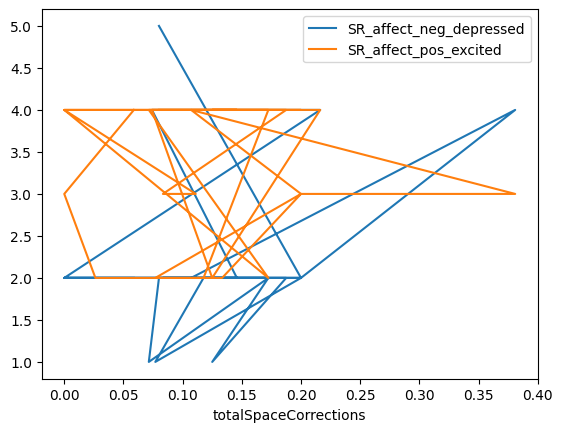

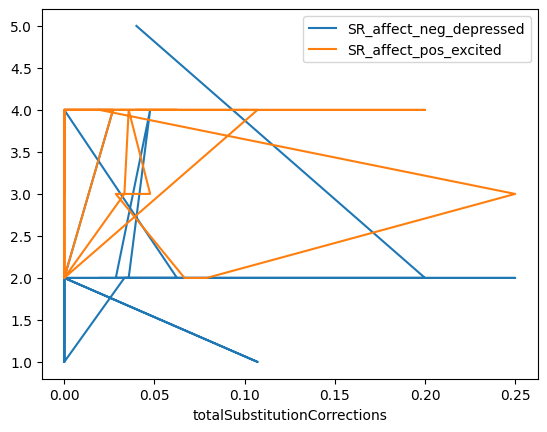

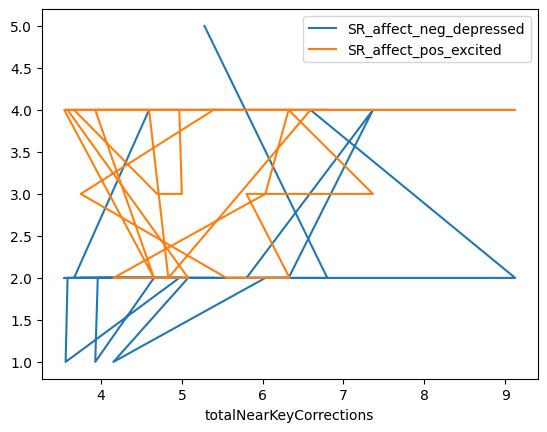

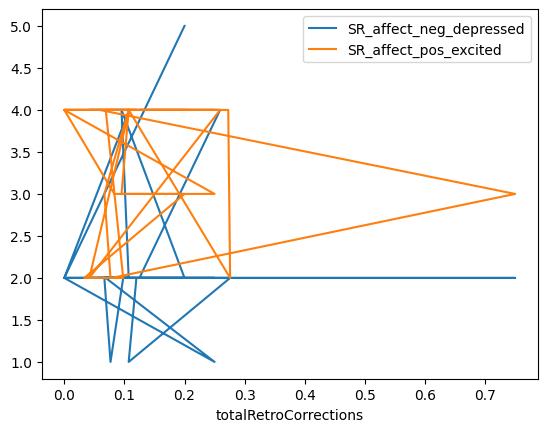

In [47]:
# temp = AverageErrorDF["spaceUpErrorDistance"].to_numpy()
# normalized_arr = preprocessing.normalize([temp])
# hist, bins = numpy.histogram(normalized_arr[0], bins=10)
# plt.hist(normalized_arr[0], bins = 10)
# totalRetroCorrections	totalNearKeyCorrections	totalSubstitutionCorrections	totalSpaceCorrection
# shortWordCharKeyUpErrorDistance	shortWordCharKeyDownErrorDistance	spaceUpErrorDistance
kikos.plot("totalSpaceCorrections", emotions)
kikos.plot("totalSubstitutionCorrections", emotions)
kikos.plot("totalNearKeyCorrections", emotions)
kikos.plot("totalRetroCorrections", emotions)

In [48]:
# ## Want to extract the keyboard metrics in a good way
# file_path = "RK.8D1DBFAD.DJW Thesis_20220930-20221001/sensorkit-keyboard-metrics/iPhone/2f32cd19-e9c5-4aad-8999-6f4646169ab6/3400296D-7399-44F9-9E9D-2CA824598AE8/2022-09-28T163510-0400_2022-09-29T071630-0400.json.gz"
# a = gzip.open(file_path, 'rb')
# contents = json.loads(a.read())
# print(pd.DataFrame(contents))
## Join the App data with this DataFrame

